In [1]:
!pip install requests scikit-learn

In [2]:
import requests
from datetime import datetime
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
COVID_LINK = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"

In [4]:
covid_data_raw = StringIO(requests.get(COVID_LINK).text)

In [5]:
df = pd.read_csv(covid_data_raw)

In [6]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [7]:
COUNTRY = "Peru"

In [8]:
df = df.loc[df["location"] == COUNTRY, :]

In [9]:
df["date"] = pd.to_datetime(df["date"])

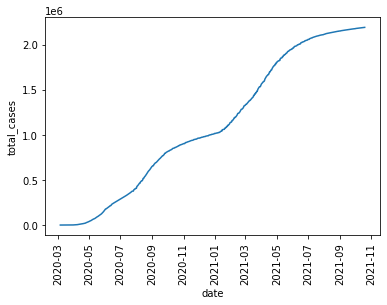

In [10]:
sns.lineplot(x="date", y="total_cases", data=df);
plt.xticks(rotation=90);

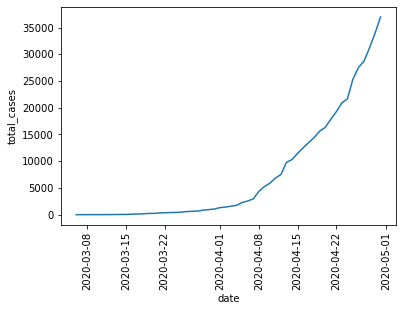

In [11]:
sns.lineplot(x="date", y="total_cases", data=df.loc[df["date"] < datetime(2020, 5, 1)]);
plt.xticks(rotation=90);

In [12]:
START_DATE = datetime(2020, 3, 15)

In [13]:
df = df.loc[df["date"] > START_DATE, :]

In [14]:
df["day_number"] = np.arange(df.shape[0]) + 1

In [15]:
train_size = int(df.shape[0] * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

In [16]:
train_df.shape, test_df.shape

((466, 66), (117, 66))

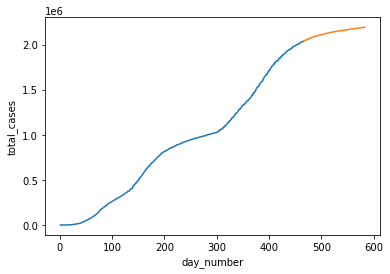

In [17]:
sns.lineplot(x="day_number", y="total_cases", data=train_df);
sns.lineplot(x="day_number", y="total_cases", data=test_df);

In [18]:
model = LinearRegression()

In [19]:
TRAIN_FEATURES = ["day_number"]

In [20]:
model.fit(train_df[TRAIN_FEATURES], train_df["total_cases"])

LinearRegression()

In [21]:
prediction = model.predict(test_df[TRAIN_FEATURES])

In [22]:
mean_squared_error(test_df["total_cases"], prediction)

17793845729.683346

## Exponent trick

In [23]:
train_df["total_cases_log"] = np.log(train_df["total_cases"])
test_df["total_cases_log"] = np.log(test_df["total_cases"])

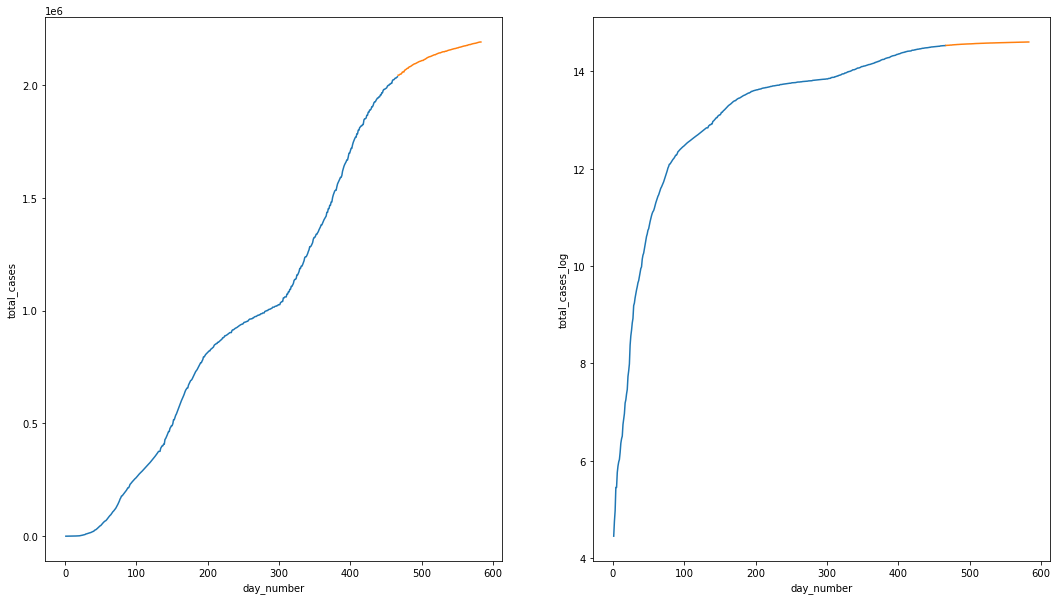

In [24]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(18)
sns.lineplot(x="day_number", y="total_cases", data=train_df, ax=ax[0], legend=True);
sns.lineplot(x="day_number", y="total_cases", data=test_df, ax=ax[0]);

sns.lineplot(x="day_number", y="total_cases_log", data=train_df, ax=ax[1]);
sns.lineplot(x="day_number", y="total_cases_log", data=test_df, ax=ax[1]);

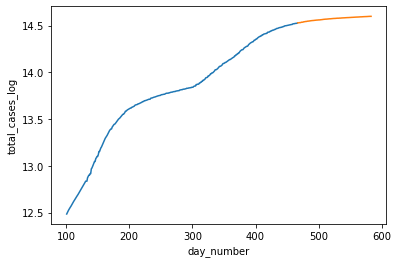

In [25]:
sns.lineplot(x="day_number", y="total_cases_log", data=train_df.loc[train_df["day_number"] > 100]);
sns.lineplot(x="day_number", y="total_cases_log", data=test_df);

## Sigmoid explanation

$$\large{\Phi(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\int_{-\infty}^{x}e^{-t^2}dt}$$

Поскольку определенный интеграл это площадь под графиком функции, которая определяется как сумма прямоугольников при $dx \rightarrow 0$, а у нас x может принимать только дискретные значения (номер дня), то валидно заменить интеграл суммой

$$\large{\Phi(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\sum_{i = -\infty}^{n}e^{-x_i^2}}$$

Номер дня у нас начинается с еденицы и мы предполагаем что наши данные распрелены по sigmoid(f(x)), где f(x) полиномиальная функция, тогда

$$\large{y_n = \frac{1}{\sqrt{2\pi\sigma^2}}\sum_{i = 1}^{n}e^{ax_i^2 + bx_i + c}}$$

Внесем константу под экспоненту

$$\large{y_n = e^{\log{\frac{1}{\sqrt{2\pi\sigma^2}}}}\sum_{i = 1}^{n}e^{ax_i^2 + bx_i + c}}$$
$$\large{y_n = \sum_{i = 1}^{n}e^{ax_i^2 + bx_i + c + \log{\frac{1}{\sqrt{2\pi\sigma^2}}}}}$$

Поскольку $c$ это тоже константа, внесем $\large{\log{\frac{1}{\sqrt{2\pi\sigma^2}}}}$ в нее

$$\large{y_n = \sum_{i = 1}^{n}e^{ax_i^2 + bx_i + c}}$$

Остается избавиться от суммы и экспоненты и мы сможем смоделировать модель, экспоненту как убрать мы знаем из предыдущего пунктов 6-7, для того чтобы избавиться от суммы:

- Понять чему равен $y_{n-1}$
- Выразить $y_{n} - y_{n-1}$
- Понять что такое $y_{n} - y_{n-1}$ физически
- Убрать экспоненту